# Variational quantum classifier 

Fix Embedding Circle, Circuit Design 3 , opt = AdamOptimizer(0.005, beta1=0.9, beta2=0.9), Data Set 2

Code Stub for a variational quantum classifier [from Pennylane, Automatic differentiation of hybrid quantum classical computations, Bergolm 2020]

A supervised learning algorithm in which variational circuits (QNNs) are trained to perform classification tasks.

In [1]:
#Libraries
import pennylane as qml
from pennylane import numpy as np
import numpy as npp
import math
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import matplotlib.pyplot as plt
from pennylane.ops import RX, RY, RZ
from pennylane.operation import Operation, AnyWires, Expectation, Observable, Sample, Probability
import time
import scipy
from IPython.display import display, Latex  

Define the device : qdev 4 wires=4qubits

In [2]:
dev = qml.device("default.qubit", wires=4)

We will now use the quantum circuit and QNode to build a variational classifier
(Variational circuits are circuits that can be trained using supervised learning or labelled data to classify new data)

# EmbeddingCircuit+Layers

We use the (feature) embedding circuit or state preparation circuit as proposed by Hubregtsen: 

Embeddings encode input features into the quantum state of the circuit. Hence, they usually take a data sample such as a feature vector as an argument. Embeddings can also depend on trainable parameters, and they may be constructed from repeated layers.

In [3]:
#2dim_data_input, data on the x axis from the generated samples is embedded in qubit 0 and 2.
#y axis data in 1 and 3

def statepreparation(x,y):
    qml.RX(x, wires=0)
    qml.RX(y, wires=1)
    qml.RX(x, wires=2)
    qml.RX(y, wires=3)
    qml.RY(np.pi/4, wires=0)
    qml.RY(np.pi/4, wires=1)
    qml.RY(np.pi/4, wires=2)
    qml.RY(np.pi/4, wires=3)
    qml.RZ(np.pi/4, wires=0)
    qml.RZ(np.pi/4, wires=1)
    qml.RZ(np.pi/4, wires=2)
    qml.RZ(np.pi/4, wires=3)

Variational classifiers usually define a “layer” or “block”, which is an elementary circuit architecture that gets repeated to build the variational circuit.



Circuit 3 - Appendix B - Hubregtsen

In [4]:
def layer(theta):
    qml.RX(theta[0], wires=0)
    qml.RX(theta[1], wires=1)
    qml.RX(theta[2], wires=2)
    qml.RX(theta[3], wires=3)
    qml.RZ(theta[4], wires=0)
    qml.RZ(theta[5], wires=1)
    qml.RZ(theta[6], wires=2)
    qml.RZ(theta[7], wires=3)
    qml.CRZ(theta[8],wires=[3, 2])
    qml.CRZ(theta[9],wires=[2, 1])
    qml.CRZ(theta[10],wires=[1, 0])

Define Qnode as statepreparation routine, followed by repetion of the layer structure
#weights=angles--# Execute layers

In [5]:
@qml.qnode(dev)
def circuit(angles, x, y):
    statepreparation(x, y)
    for theta in angles:
        layer(theta)
    op0 = qml.Hermitian(np.array([[0, 0], [0, 1]]), wires=0)
    op1 = qml.Hermitian(np.array([[0, 0], [0, 1]]), wires=1)
    op2 = qml.Hermitian(np.array([[0, 0], [0, 1]]), wires=2)
    op3 = qml.Hermitian(np.array([[0, 0], [0, 1]]), wires=3)
    op_tot = qml.Hamiltonian([1, 2, 4, 8], [op0, op1, op2, op3])
    return qml.expval(op_tot)
        

def convert_output(angles, x, y) -> int:
    output = circuit(angles, x, y) 
    return 2*output/15 - 1

# Variational Classifier/ Variationale Learner

In [6]:
def model(x, var):
    theta = var[0]
    bias = var[1]
    return circuit(angles, x) + bias

#model=variational classifier

# Cost

In [7]:
# Compute loss
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [8]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss


For learning tasks, the cost depends on the data - here the features and labels considered in the iteration of the optimization routine.

In [9]:
def cost(var, features_x, features_y, labels):
    preds = []
    for k in range(0, len(features_x)):
        preds.append(convert_output(var, features_x[k], features_y[k]))
    # preds = [convert_output_to_bit(var, x, y) for x in features_x for y in features_y]
    return square_loss(labels, preds)

# Generating different artifical DataSets 

We generate different Data Sets for the Optimization process

# Data Set2


DatasetFig2a, 3.2 (lin3,col2), Hubregtsen2020
Make a dataset of points inside and outside of two non bordering circles. Here we can try out different data sets as suggested.


(1500,)
(1500,)
1500
          x         y  labels
0  0.680428  0.440657      -1
1  0.772610  0.901413      -1
2  0.561916  0.037813      -1
3  0.552443  0.331679      -1
4  0.151198  0.077160      -1


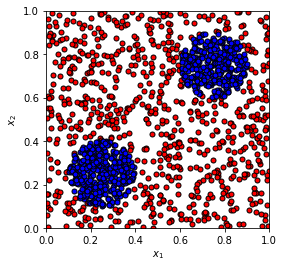

In [10]:
def isnotcontainedinanycircle(centers, radius, x, y):
    for center in centers:
        if np.sqrt((x-center[0])**2 + (y - center[1])**2) < radius:
            return False
    return True

def circle(samples, centers=[[0.25, 0.25],[0.75,0.75]], radius=0.15):
    labels = []
    xlist = []
    ylist = []
    
    while len(labels) < int(samples/2):
        x = np.random.rand()
        y = np.random.rand()
        if isnotcontainedinanycircle(centers, radius, x, y):
            labels.append(-1)
            xlist.append(x)
            ylist.append(y) 
            
    while len(labels) < samples:
        x = np.random.rand()
        y = np.random.rand()
        if not isnotcontainedinanycircle(centers, radius, x, y):
            labels.append(1)
            xlist.append(x)
            ylist.append(y)
    
    xvals = np.array(xlist, requires_grad = True)
    yvals = np.array(ylist, requires_grad = True)
    
    return xvals, yvals, labels

import pandas as pd


def plot_data(xvals, yvals,labels, fig=None, ax=None):
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    #reds = labels == -1
    #blues = labels == 1    ""="" = zuweisung ""=="" = überprüfung auf gleichheiht
    
    df = pd.DataFrame()
    df['x'] = xvals
    df['y'] = yvals
    df['labels'] = labels
    print(df.head())
    
    df_minus_one = df[df['labels']==-1]
    df_plus_one = df[df['labels']==1]
    
    #print(df_plus_one.head())
    #print(df_minus_one.shape)
    
    ax.scatter(df_minus_one['x'], df_minus_one['y'], c="red", s=25, edgecolor="k")
    ax.scatter(df_plus_one['x'], df_plus_one['y'], c="blue", s=25, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    
    

xvals, yvals, labels = circle(1500)

print(xvals.shape)
print(yvals.shape)
print(len(labels))

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(xvals, yvals, labels, fig=fig, ax=ax)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

# Optimization 

We can train the classifier to generalize the input-output relation of a training dataset.

The variables are initialized as a tuple containing the bias and the weight matrix. 
In the optimization loop, we feed a Python lambda function into the optimizer. 
Since the optimizer expects a function with a single input argument,
this is a way to feed both X and Y into the cost.

In [11]:
n_samples = 100
x_data, y_data, labels_data = circle(n_samples)

In [12]:
n_samples =1500
x_data, y_data, labels_data = circle(n_samples)
# Generate training and test data
num_training = 900
num_test = 300

x_data, y_train, labels = circle(num_training)
x_train = np.hstack((x_data, np.zeros([x_data.shape[0], 1])))

xtest, y_test, labels = circle(num_test)
x_test = np.hstack((xtest, np.zeros(([xtest.shape[0], 1])))

In [13]:
n_layers = 1
n_params = 11 #numbers of params per layer
var_init= [np.random.rand(n_params)*2 - 1 for _ in range(n_layers)]
print(var_init)

[tensor([-0.66505399,  0.30641023, -0.29749919, -0.88368907, -0.49935055,
        -0.15732029, -0.32769707, -0.43834738,  0.79943364,  0.76833104,
        -0.84632585], requires_grad=True)]


# Adam Optimizer

In [14]:
# Create optimizer 
opt = AdamOptimizer(0.005, beta1=0.9, beta2=0.9)


# Train the model = optimize circuit output

Iter:     0 | Cost: 1.3535069 
Iter:     1 | Cost: 1.3499114 
Iter:     2 | Cost: 1.3472130 
Iter:     3 | Cost: 1.3448977 
Iter:     4 | Cost: 1.3428012 
Iter:     5 | Cost: 1.3408471 
Iter:     6 | Cost: 1.3389925 
Iter:     7 | Cost: 1.3372105 
Iter:     8 | Cost: 1.3354831 
Iter:     9 | Cost: 1.3337973 
Iter:    10 | Cost: 1.3321437 
Iter:    11 | Cost: 1.3305149 
Iter:    12 | Cost: 1.3289052 
Iter:    13 | Cost: 1.3273101 
Iter:    14 | Cost: 1.3257260 
Iter:    15 | Cost: 1.3241499 
Iter:    16 | Cost: 1.3225792 
Iter:    17 | Cost: 1.3210119 
Iter:    18 | Cost: 1.3194463 
Iter:    19 | Cost: 1.3178808 
Iter:    20 | Cost: 1.3163142 
Iter:    21 | Cost: 1.3147455 
Iter:    22 | Cost: 1.3131737 
Iter:    23 | Cost: 1.3115980 
Iter:    24 | Cost: 1.3100179 
Iter:    25 | Cost: 1.3084326 
Iter:    26 | Cost: 1.3068417 
Iter:    27 | Cost: 1.3052448 
Iter:    28 | Cost: 1.3036416 
Iter:    29 | Cost: 1.3020317 
Iter:    30 | Cost: 1.3004149 
Iter:    31 | Cost: 1.2987910 
Iter:   

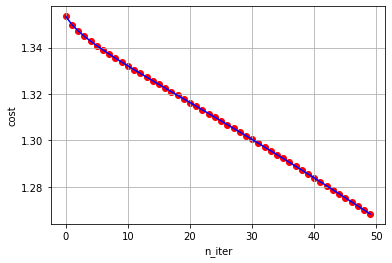

Computation time = 270.9502007961273 s


In [16]:
import pickle as p

n_iter = 50

start = time.time()

var = var_init
retval = []
for it in range(n_iter):
    var, _cost = opt.step_and_cost(lambda v: cost(v, x_data, y_data, labels_data),var)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it, _cost))
    retval.append([it,_cost])
    
end = time.time()
with open('/Users/ariane/pennysboat/Aricatlover66/klausdetle.detle','wb') as f:
    p.dump(retval,f)
    
plt.figure()
retval = np.array(retval)

plt.scatter(retval[:,0],retval[:,1],color=[1,0,0])
plt.plot(retval[:,0],retval[:,1],color=[0,0,1])
plt.grid()
plt.xlabel('n_iter')
plt.ylabel('cost')
plt.show()
 
print('Computation time = {} s'.format(end - start))